# **Alzheimer's Disease Detection**

**Loading the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Import Statements**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.image as img
%matplotlib inline

split-folders is a python package to split a dataset into training, validation, and test sets

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1))

Copying files: 6400 files [01:51, 57.60 files/s]


tf.keras.preprocessing.image_dataset_from_directory function to create TensorFlow tf.data.Dataset objects from the image datasets that were previously split and saved in the "output" directory.

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
                                                               )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

This code snippet is using Matplotlib to visualize a grid of images from the training dataset. It generates a 3x3 grid displaying the first 9 images from the training dataset, along with their corresponding class labels.

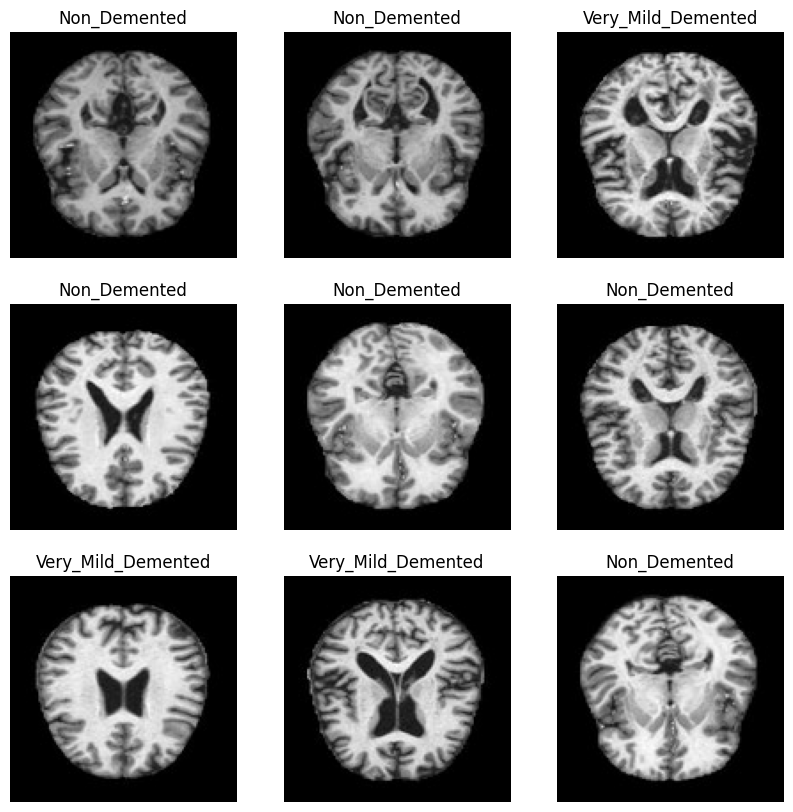

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

This bar plot shows the distribution or counts of different classes within the dataset.

<function matplotlib.pyplot.show(close=None, block=None)>

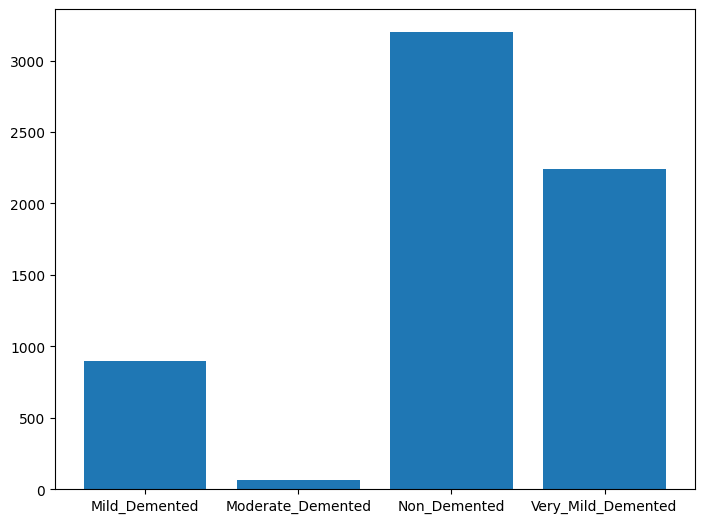

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

## **ResNet (Residual Network)**



**Loading the model**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3))

base_model.trainable = True

# Create a new model on top
modelRes = Sequential()
modelRes.add(base_model)
modelRes.add(GlobalAveragePooling2D())
modelRes.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
modelRes.add(keras.layers.Dense(4,"softmax"))  # 4 classes: mild_demented, moderate_demented, non_demented, very_mild_demented

# Compile the model
modelRes.compile(loss="sparse_categorical_crossentropy",
              optimizer = Adam(learning_rate = 0.0002),metrics=["accuracy"])

# Summary of the model architecture
modelRes.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_29 (Dense)            (None, 128)               262272    
                                                                 
 dense_30 (Dense)            (None, 4)                 516       
                                                                 
Total params: 23850500 (90.98 MB)
Trainable params: 23797380 (90.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


**Training the model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = modelRes.fit(train_ds, validation_data=val_ds,epochs=50, batch_size=32, verbose=1, callbacks=[early_stop])

Epoch 1/50
80/80 [==============================] - 93s 231ms/step - loss: 0.6503 - accuracy: 0.7220 - val_loss: 1.3477 - val_accuracy: 0.6322
Epoch 2/50
80/80 [==============================] - 17s 215ms/step - loss: 0.1867 - accuracy: 0.9322 - val_loss: 1.4000 - val_accuracy: 0.7261
Epoch 3/50
80/80 [==============================] - 18s 224ms/step - loss: 0.1153 - accuracy: 0.9594 - val_loss: 2.8860 - val_accuracy: 0.5915
Epoch 4/50
80/80 [==============================] - 18s 220ms/step - loss: 0.0780 - accuracy: 0.9728 - val_loss: 1.0538 - val_accuracy: 0.6792
Epoch 5/50
80/80 [==============================] - 18s 219ms/step - loss: 0.0497 - accuracy: 0.9834 - val_loss: 0.5162 - val_accuracy: 0.8545
Epoch 6/50
80/80 [==============================] - 18s 221ms/step - loss: 0.0341 - accuracy: 0.9896 - val_loss: 0.3992 - val_accuracy: 0.8873
Epoch 7/50
80/80 [==============================] - 18s 227ms/step - loss: 0.0263 - accuracy: 0.9924 - val_loss: 0.7340 - val_accuracy: 0.8466

**Testing Analysis**

In [ ]:
loss, accuracyRes = modelRes.evaluate(test_ds)
print(f"Test Accuracy: {accuracyRes:.4f}")


11/11 [==============================] - 1s 60ms/step - loss: 0.0853 - accuracy: 0.9798
Test Accuracy: 0.9798


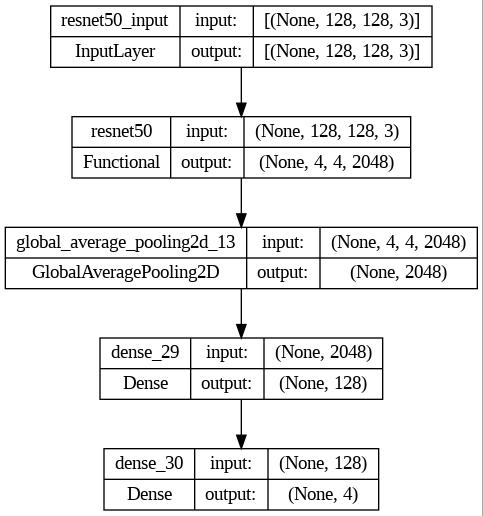

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(modelRes,to_file='model_res_architecture.jpg',show_shapes=True,show_layer_names=True)

In [ ]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

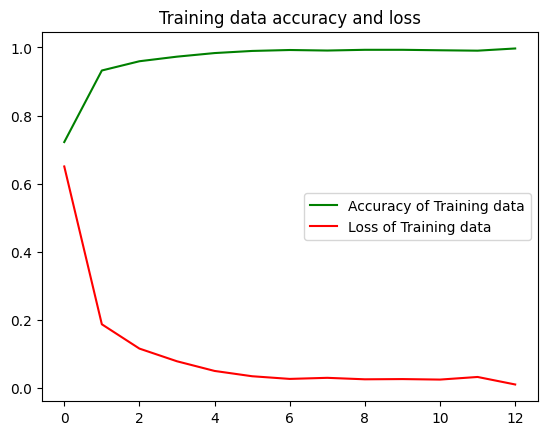

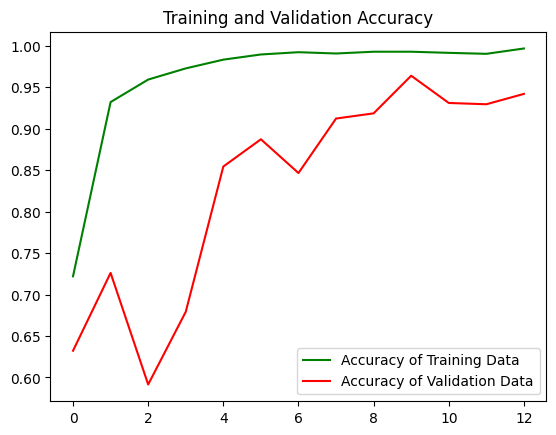

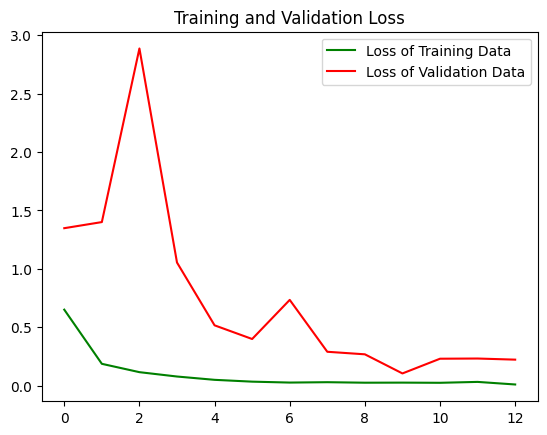

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

1/1 [==============================] - 0s 30ms/step


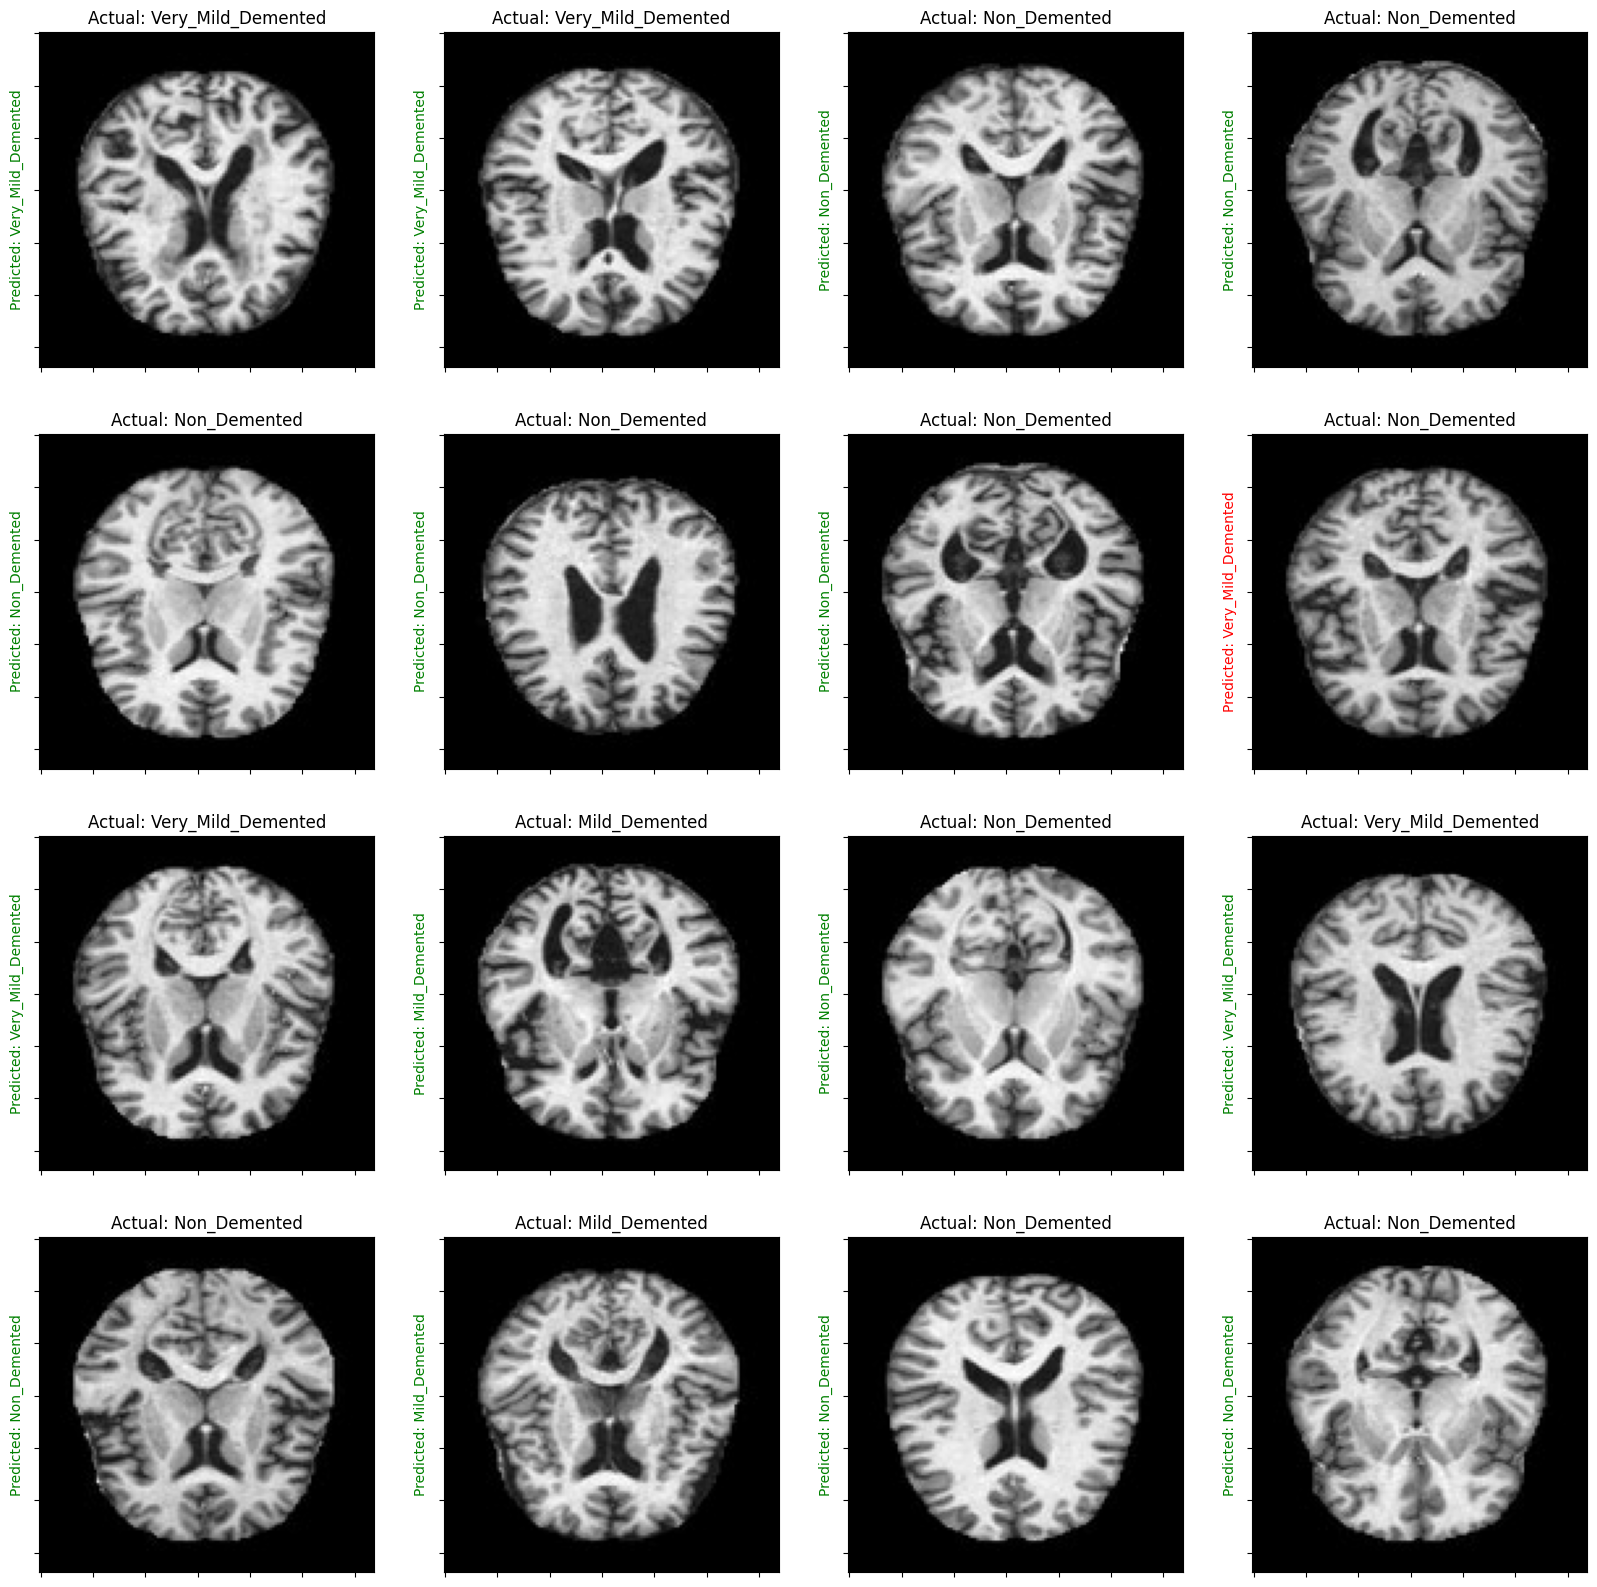

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = modelRes.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})

        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])